Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

1. Creating data generators...
Found 5768 images belonging to 2 classes.
Found 1440 images belonging to 2 classes.
Found 7208 images belonging to 2 classes.

2. Creating model...

3. Training model...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8157 - auc: 0.8881 - loss: 0.3880 - precision: 0.7975 - recall: 0.7939
Epoch 1: val_accuracy improved from -inf to 0.97778, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 1562s 8s/step - accuracy: 0.8162 - auc: 0.8885 - loss: 0.3872 - precision: 0.7979 - recall: 0.7943 - val_accuracy: 0.9778 - val_auc: 0.9978 - val_loss: 0.0804 - val_precision: 0.9903 - val_recall: 0.9592 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.

4. Evaluating model...
226/226 ━━━━━━━━━━━━━━━━━━━━ 1275s 6s/step - accuracy: 0.9805 - auc: 0.4485 - loss: 0.0481 - precision: 0.4474 - recall: 0.3778

Test Metrics:
loss: 0.1763
accuracy: 0.9247
auc: 0.9980
precision: 0.9992
recall: 0.8306

5. Generating final plots...


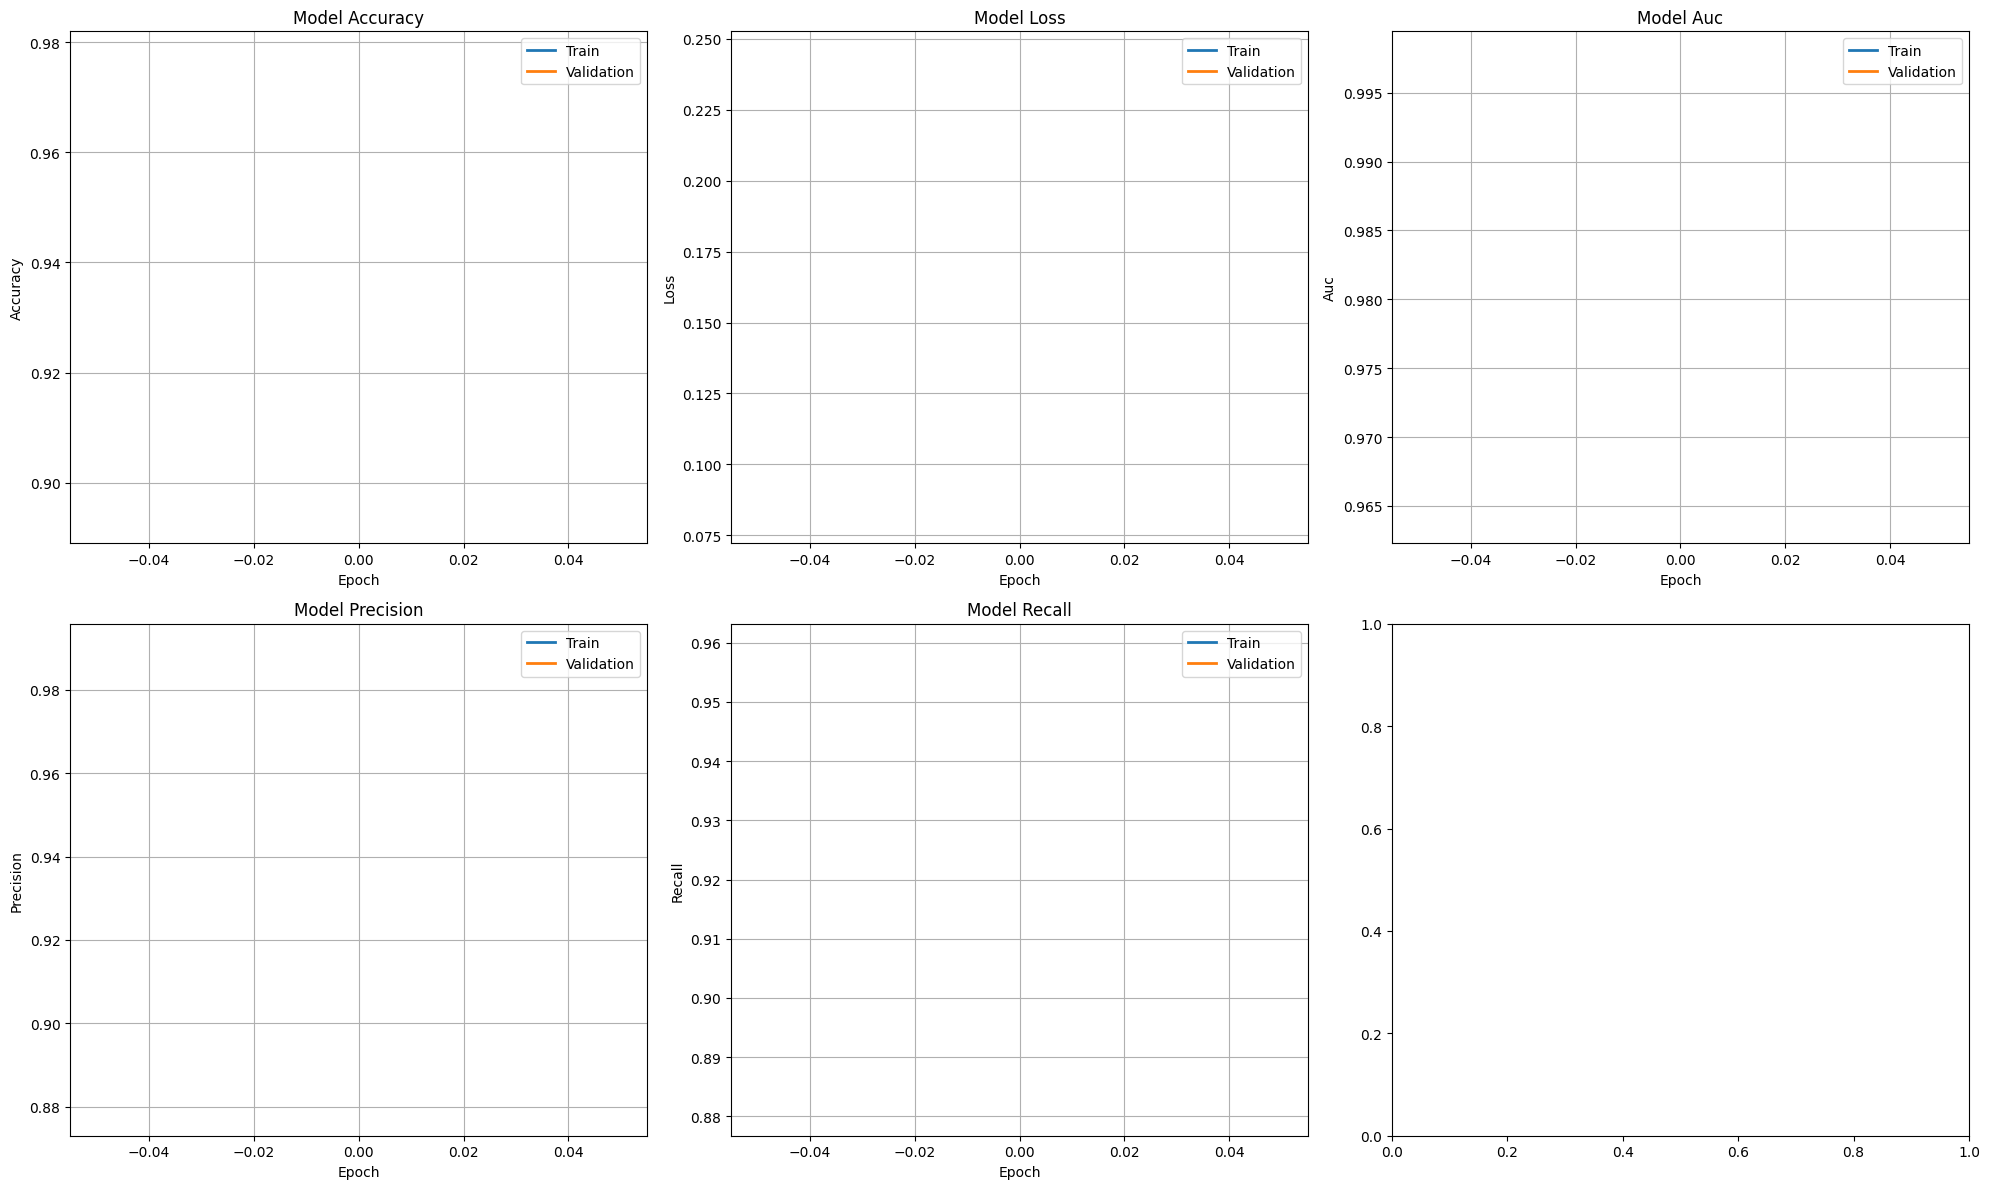

226/226 ━━━━━━━━━━━━━━━━━━━━ 1278s 6s/step


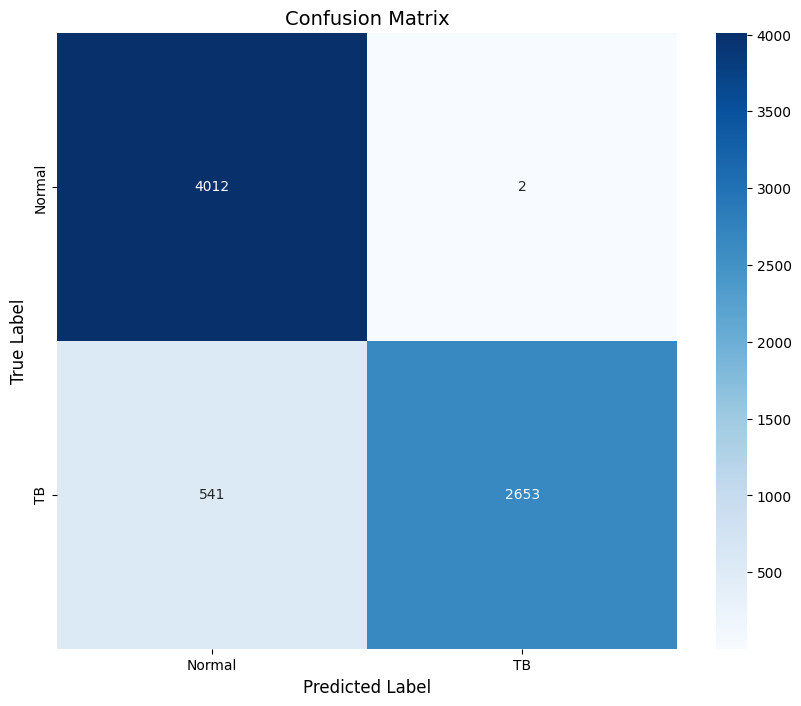


True Negatives (Normal correctly classified): 4012
False Positives (Normal incorrectly classified as TB): 2
False Negatives (TB incorrectly classified as Normal): 541
True Positives (TB correctly classified): 2653

Sensitivity (True Positive Rate): 0.8306
Specificity (True Negative Rate): 0.9995

6. Saving model...
Model saved successfully to /content/drive/MyDrive/trained_models/final_tb_model.keras


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from sklearn.metrics import confusion_matrix
import seaborn as sns
import gc
from google.colab import drive
from IPython.display import display, clear_output

# Mount Google Drive
drive.mount('/content/drive')

def create_data_generators(base_dir, image_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Ensure balanced sampling
    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=True,
        seed=42
    )

    validation_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=True,
        seed=42
    )

    test_generator = test_datagen.flow_from_directory(
        base_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False  # Important for consistent evaluation
    )

    return train_generator, validation_generator, test_generator

def create_model(image_size=(224, 224)):
    tf.keras.backend.clear_session()
    gc.collect()

    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(*image_size, 3)
    )

    # Freeze fewer layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]
    )

    return model

def plot_training_history(history):
    metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        if metric in history.history:
            axes[idx].plot(history.history[metric], label='Train', linewidth=2)
            axes[idx].plot(history.history[f'val_{metric}'], label='Validation', linewidth=2)
            axes[idx].set_title(f'Model {metric.capitalize()}', fontsize=12)
            axes[idx].set_xlabel('Epoch', fontsize=10)
            axes[idx].set_ylabel(metric.capitalize(), fontsize=10)
            axes[idx].legend(fontsize=10)
            axes[idx].grid(True)

    plt.tight_layout()
    display(plt.gcf())
    plt.close()

def plot_confusion_matrix(test_generator, model, threshold=0.5):
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > threshold).astype(int)
    true_classes = test_generator.classes

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'TB'],
                yticklabels=['Normal', 'TB'])
    plt.title('Confusion Matrix', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    display(plt.gcf())
    plt.close()

    # Print classification metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\nTrue Negatives (Normal correctly classified): {tn}")
    print(f"False Positives (Normal incorrectly classified as TB): {fp}")
    print(f"False Negatives (TB incorrectly classified as Normal): {fn}")
    print(f"True Positives (TB correctly classified): {tp}")

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"\nSensitivity (True Positive Rate): {sensitivity:.4f}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

def train_model(model, train_generator, validation_generator, epochs=30):
    # Calculate class weights
    total_samples = train_generator.n
    n_samples_0 = len([x for x in train_generator.classes if x == 0])
    n_samples_1 = len([x for x in train_generator.classes if x == 1])

    class_weights = {
        0: total_samples / (2 * n_samples_0),
        1: total_samples / (2 * n_samples_1)
    }

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,
    )

    return history

def main():
    # ... (previous GPU configuration remains the same)

    # Updated configuration
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 32  # Increased batch size
    EPOCHS = 1      # Increased epochs
    BASE_DIR = '/content/drive/MyDrive/TB-Dataset'

    try:
        print("\n1. Creating data generators...")
        train_generator, validation_generator, test_generator = create_data_generators(
            BASE_DIR,
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE
        )

        print("\n2. Creating model...")
        model = create_model(image_size=IMAGE_SIZE)

        print("\n3. Training model...")
        history = train_model(
            model,
            train_generator,
            validation_generator,
            epochs=EPOCHS
        )

        print("\n4. Evaluating model...")
        test_results = model.evaluate(test_generator, verbose=1)
        metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']

        print("\nTest Metrics:")
        for metric, value in zip(metrics, test_results):
            print(f"{metric}: {value:.4f}")

        print("\n5. Generating final plots...")
        plot_training_history(history)
        plot_confusion_matrix(test_generator, model)

        print("\n6. Saving model...")
        save_path = '/content/drive/MyDrive/trained_models/final_tb_model.keras'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        model.save(save_path)
        print(f"Model saved successfully to {save_path}")

    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        raise e

    finally:
        tf.keras.backend.clear_session()
        gc.collect()

if __name__ == "__main__":
    main()